In [192]:
import re
from typing import List
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import json
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
from zipfile import ZipFile
import seaborn as sb
import plotly.graph_objects as go
from collections import Counter

In [432]:
# Make sure you've done this once in your environment:
# import nltk
# nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

def clean_text(text: str) -> str:
    """
    Remove punctuation except apostrophes inside words.
    Keep words inside parentheses, but drop the parentheses themselves.
    """
    # Remove parentheses but keep what's inside
    text = text.replace("(", "").replace(")", "")
    # Remove other punctuation except apostrophes inside contractions
    text = re.sub(r"[^\w\s']+", " ", text)
    return text

def tokenize_keep_contractions(text: str) -> List[str]:
    """
    Tokenize text into lowercase tokens while preserving contractions.
    """
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    return tknzr.tokenize(text)

def preprocess_lyrics(raw_text: str) -> List[str]:
    """
    Steps:
      1. remove punctuation (but keep apostrophes inside words)
      2. tokenize (keeps contractions)
      3. remove NLTK stopwords automatically
    Returns: list of tokens.
    """
    text = clean_text(raw_text)
    tokens = tokenize_keep_contractions(text)
    tokens = [t for t in tokens if t.lower() not in STOPWORDS]
    return tokens


def count_swears(tokens):
    # allowed ass variants
    ass_variants = {
        "ass", "asshole", "assholes", "asswipe", "asshat", "jackass", "jackasses",
        "dumbass", "smartass", "badass", "hardass", "lameass", "punkass"
    }

    dick_variants = {"dick", "dicked", "dicking", "dicks", "dickhead"}

    counts = Counter({s: 0 for s in ['shit', 'bitch', 'damn', 'dick', 'fuck', 'ass', 'hell']})

    for tok in tokens:
        t = tok.lower()

        if "fuck" in t:  # fuck, fucking, motherfucker, etc.
            counts["fuck"] += 1

        elif t in ass_variants:
            counts["ass"] += 1

        elif t.startswith("shit"):  # shit, shits, shitty, shithead
            counts["shit"] += 1

        elif t.startswith("bitch"):  # bitch, bitches, bitching
            counts["bitch"] += 1

        elif "damn" in t:  # damn, goddamn, damned, dammit
            counts["damn"] += 1

        elif t in dick_variants:  # dick, dicks, dickhead
            counts["dick"] += 1

        # include hella, but do not include hell, hellish, hellbent
        elif t.startswith("hell"):  # hell, hellish, etc.
            if 'hello' not in t:
                counts["hell"] += 1

    return counts

In [434]:
def create_data():
	with ZipFile('data1 (2).zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data1.pkl') as pkl_file:
	        # Load the pickle data
	        data1 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data2.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data2.pkl') as pkl_file:
	        # Load the pickle data
	        data2 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data3.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data3.pkl') as pkl_file:
	        # Load the pickle data
	        data3 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data4.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data4.pkl') as pkl_file:
	        # Load the pickle data
	        data4 = pd.read_pickle(pkl_file)


	final = pd.concat([data1, data2, data3, data4])
	final = pd.concat([final.iloc[:,0:6], final.iloc[:,11:]], axis = 1)

	return final

f = create_data()
f = f.iloc[:,:6]
f = f[f['date'] > '1980']

In [435]:
swears = ['shit', 'bitch', 'damn','dick', 'fuck', 'ass', 'hell']

In [436]:
unique = f.drop_duplicates(subset = ['title', 'artist'])
unique = unique.reset_index(drop = True)
unique['tokens'] = [preprocess_lyrics(t) for t in unique['cleaned_lyrics']]
num_swears = [count_swears(tokens) for tokens in unique['tokens']]
swear_df = pd.DataFrame(num_swears)
unique = pd.concat([unique, swear_df], axis = 1)

In [437]:
unique['tot_words'] = [len(tokens) for tokens in unique['tokens']]
unique['unique_words'] = [len(set(tokens)) for tokens in unique['tokens']]

In [438]:
unique['total_swear'] = unique.iloc[:, -9:-2].sum(axis = 1)
unique['percent_swear'] = unique['total_swear'] / unique['tot_words']
unique['percent_swear_unique_words'] = unique['total_swear'] / unique['unique_words']
unique['year'] = [date.split('-')[0] for date in unique['date']]

In [439]:
unique = unique.drop(['date', 'cleaned_lyrics', 'rank'], axis = 1)

In [440]:
f = f.drop(['tokens'], axis = 1)
f = pd.merge(f, unique, left_on=['title', 'artist'], right_on=['title', 'artist'], how = 'left')

### Find Highest Sweary Song Every 5 Years

In [139]:
# Group data by every 5 years
# Find the highest sweary song in each subset

In [140]:
highest_sweary_song = pd.DataFrame(columns = f.columns)
for yr in range(1980,2024, 5):
    temp = f[(f['year'] >= str(yr)) & (f['year'] <= str(yr + 4))]
    idx = temp['total_swear'].idxmax()
    highest_sweary_song.loc[yr] = temp.loc[idx]

### Highest Ranking Sweary Song 

In [143]:
ranking_sweary_song = pd.DataFrame(columns = f.columns)
for yr in range(1980,2024):
    temp = f[(f['year'] == str(yr)) & (f['total_swear'] != 0)]
    idx = temp['rank'].idxmin()
    ranking_sweary_song.loc[yr] = temp.loc[idx]

In [145]:
ranking_sweary_song_more_5 = pd.DataFrame(columns = f.columns)
for yr in range(1980,2024):
    temp = f[(f['year'] == str(yr)) & (f['total_swear'] >= 5)]

    if len(temp) < 1:
        continue
    idx = temp['rank'].idxmin()
    ranking_sweary_song_more_5.loc[yr] = temp.loc[idx]

### Unique Swears Songs

### Get Data To Automatically Update For The Top Section

In [335]:
total_songs = len(f)
unique_songs = len(unique)
unique_1_swear = round(len(unique[unique['total_swear'] > 0])/len(unique),3) * 100
on_avg = round(unique['total_swear'].sum()/len(unique), 2)
swear_avg_1 = round(unique['total_swear'].sum()/(unique['total_swear'] != 0).sum(), 2)

In [336]:
with open("data_front_page.txt", "w") as file:
    file.write(f"{total_songs:,}" + "\n")
    file.write(f"{unique_songs:,}" + "\n")
    file.write(str(unique_1_swear) + "%" + "\n")
    file.write(str(on_avg) + "\n")
    file.write(str(swear_avg_1) + "\n")

In [337]:
non_zero_counts = (unique.iloc[:, 3:10] != 0).sum(axis=0)

### Get Data For What % of Unique Songs Have Each Swear

In [368]:
which_swear = pd.DataFrame(columns = swears)
idx = ''
for s in swears:
    which_swear.loc[idx, s] = str(round(((unique[s] != 0).sum()/len(unique)) * 100, 2)) + '%'

In [370]:
which_swear

,shit,bitch,damn,dick,fuck,ass,hell
,14.79%,12.84%,9.52%,3.66%,16.13%,8.28%,7.03%


In [372]:
which_swear.to_csv('counts.csv')

In [350]:
unique_ey = unique.copy()
unique_ey['year'] = list(f.drop_duplicates(subset=['artist', 'title'], keep="first")['year'])

In [352]:
which_swear = pd.DataFrame(columns = swears)
for i in range(1980, 2030, 10):
    data = unique_ey[(unique_ey['year'] >= str(i)) & (unique_ey['year'] <= str(i + 10))]
    for s in swears:
        which_swear.loc[i, s] = str(round(((data[s] != 0).sum()/len(data)) * 100, 2)) + '%'

In [354]:
which_swear

,shit,bitch,damn,dick,fuck,ass,hell
1980,0.27%,0.19%,1.74%,0.07%,0.29%,0.24%,2.35%
1990,9.19%,5.93%,7.73%,2.87%,8.67%,7.51%,6.51%
2000,14.07%,10.54%,11.38%,3.14%,14.64%,10.33%,7.84%
2010,27.33%,26.61%,14.84%,7.09%,30.84%,12.95%,9.61%
2020,37.11%,33.8%,17.52%,8.48%,41.16%,15.16%,12.02%


In [356]:
which_swear.to_csv('counts_byyear.csv')

In [358]:
# Melt DataFrame to long format for Plotly

which_swear = pd.DataFrame(columns = swears)
for i in range(1980, 2030, 10):
    data = unique_ey[(unique_ey['year'] >= str(i)) & (unique_ey['year'] <= str(i + 10))]
    for s in swears:
        which_swear.loc[i, s] = (round(((data[s] != 0).sum()/len(data)) * 100, 2))
df_melted = which_swear.reset_index().melt(id_vars="index", var_name="Line", value_name="Value")

# Line plot
fig = px.line(
    df_melted,
    x="index",
    y="Value",
    color="Line",
    title="What percent of songs with each swear across the 5 decades",
    labels={"index": "X-axis", "Value": "Y-axis"}
)

fig.update_layout(
	xaxis_title="Year",
	yaxis_title="Percent of Songs",
    height = 500,
    width = 900
)

x = list(range(1980, 20230, 10))

# Set x-axis ticks to only even values
fig.update_xaxes(
    tickvals=[i for i in x if i % 2 == 0]
)

# Save figure to JSON file
with open("swears_bydecade.json", "w") as file:
    file.write(fig.to_json())

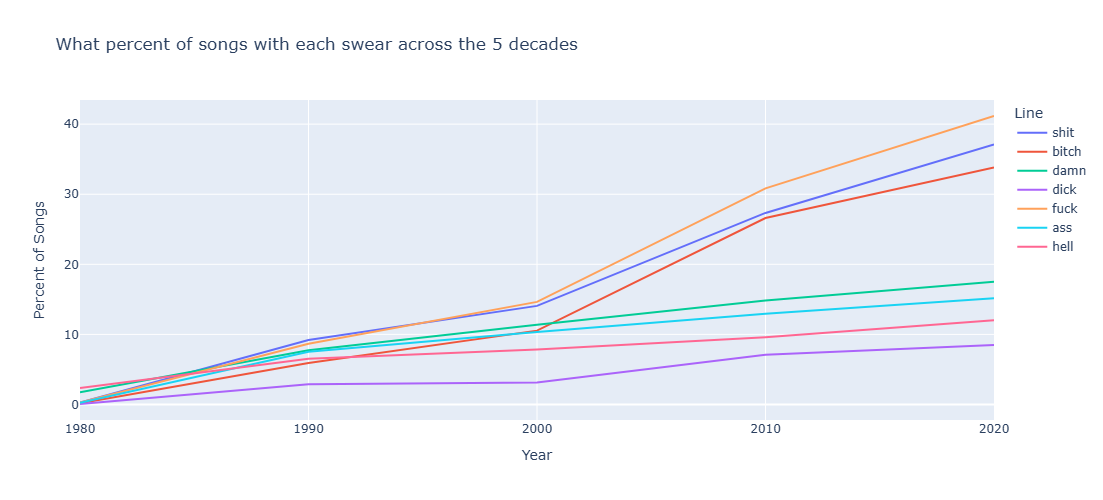

In [360]:
fig

In [362]:
which_swear = pd.DataFrame(columns = swears)
for i in range(1980, 2030, 10):
    data = unique[(unique['year'] >= str(i)) & (unique['year'] <= str(i + 10))]
    for s in swears:
        which_swear.loc[i, s] = (round(((data[s] != 0).sum())))

In [364]:
which_swear

,shit,bitch,damn,dick,fuck,ass,hell
1980,11,8,72,3,12,10,97
1990,301,194,253,94,284,246,213
2000,470,352,380,105,489,345,262
2010,1072,1044,582,278,1210,508,377
2020,661,602,312,151,733,270,214


In [366]:
which_swear.to_csv('rawnumber_byyear.csv')

# Ranks Page

In [374]:
vals = pd.DataFrame(columns = ['title', 'artist', 'rank', 'total_swear', 'percent_swear'])

for row, col in f.groupby(['title', 'artist']):
    v = col.iloc[0]
    vals.loc[len(vals)] = (v.title, v.artist, (min(col['rank'])), v.total_swear, v.percent_swear)


        

In [375]:
vals.to_csv('rank_impact_on_swearing.csv')

In [376]:
dta = pd.DataFrame(columns = [1, 3, 5, 10, 15, 20], index = range(1,101))
for i in [1, 3, 5, 10, 15, 20]:
    dta[i] = vals[vals['total_swear'] >= i].groupby('rank').count()['title']/vals.groupby('rank').count()['title']

In [377]:
dta.to_csv('swear_words_by_rank.csv')

# Distribution Page

In [385]:
dist_data = pd.DataFrame(index = f['date'].unique(), columns = [1, 2, 5, 10])

In [387]:
for num in [1, 2, 5, 10]:
    dta = []
    for idx, data in f.groupby('date'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta
    

In [388]:
dist_data.to_csv('percent_dist.csv')

###### Of All The Songs That Have Swears, What is the Most Common Number of Swears

In [392]:
num_swears = unique[(unique['total_swear'] > 0) & (unique['total_swear'] <= 40)]['total_swear']

In [394]:
# Make histogram with one bar per integer
import json

fig = px.histogram(
    x=num_swears,
    nbins=40,                # total number of bins
    labels={'x': 'Value', 'y': 'Count'},
    title = 'Distribution of Number of Swears in Songs That Have Swears'
)

# Force x-axis ticks from 1 to 40
#fig.update_xaxes(dtick=1, range=[0.5, 40.5])
fig.update_layout(
	xaxis_title="Number of Swears",
	yaxis_title="Number of Songs",

)

# Save figure to JSON file
with open("dist_swears.json", "w") as file:
    file.write(fig.to_json())

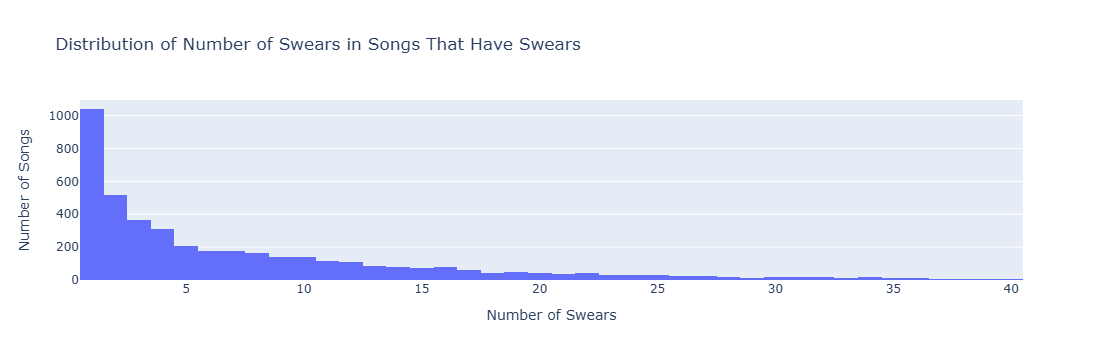

In [396]:
import plotly.io as pio

# Load figure from JSON file
with open("dist_swears.json", "r") as file:
    fig = pio.from_json(file.read())
fig

###### Most Common Swear in Songs That Only Have 1, 2, 5, 10+

In [422]:
df = pd.DataFrame(columns = (1, 2, 5, 10), index = swears)

In [424]:
for i in [1, 2, 5, 10]:
    if i == 10:
        t = unique[unique['total_swear'] >= 10]
    else:
        t = unique[unique['total_swear'] == i]
    df[i] = (t[swears] != 0).sum(axis=0)/len(t)
    
df.columns = ["1", "2", "5", "10 or more"]
df.to_csv('dist.csv')

# Which Swear Page

In [445]:
### Top song each year
data = pd.DataFrame(columns = f.columns)
for idx, dta in f.groupby('year'):
    row = dta.loc[dta["total_swear"].idxmax()]
    data.loc[idx] = row

data = data.drop(['date', 'cleaned_lyrics', 'tokens', 'unique_words', 'percent_swear_unique_words', 'year'], axis = 1)
data.to_csv('most_byyear.csv')

In [ ]:
# How many songs does it appear in
which_swear = pd.DataFrame(columns = swears)
for idx, data in f.groupby('year'):
    for s in swears:
        which_swear.loc[idx, s] = ((data[s] != 0).sum()/len(data))
which_swear.to_csv('which_swear.csv')

# Others

In [103]:
swear_only = f[f['total_swear'] > 0]
dist_data = pd.DataFrame(index = swear_only['year'].unique(), columns = [2, 5, 10, 20])
for num in [2, 5, 10, 20]:
    dta = []
    for idx, data in swear_only.groupby('year'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta

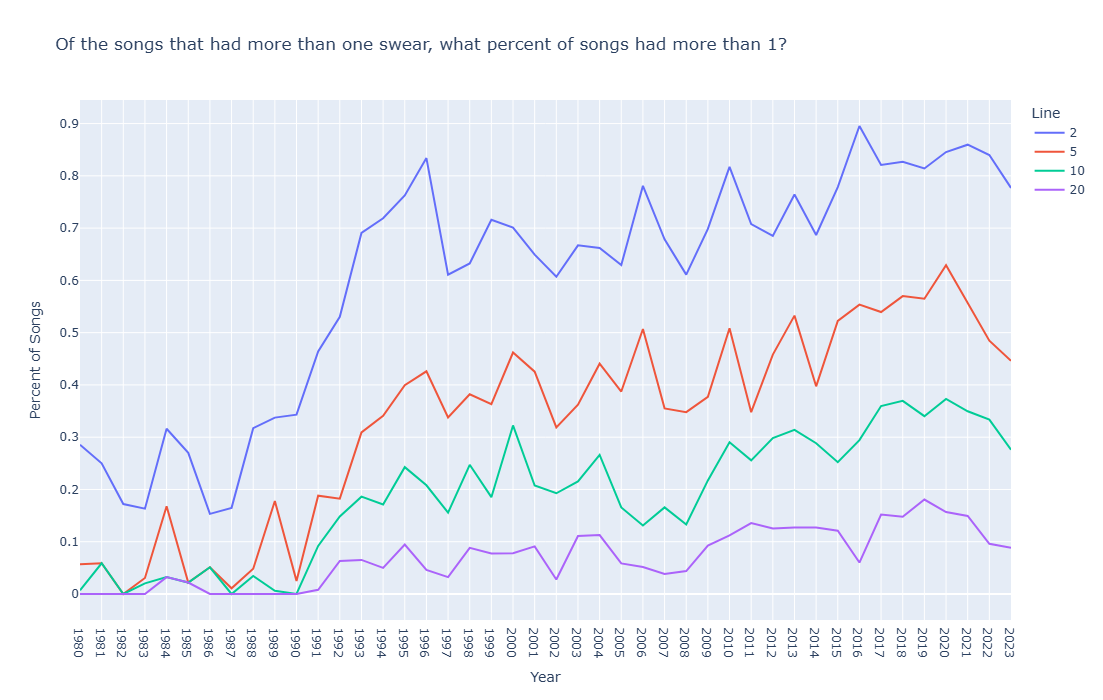

In [114]:
# Melt DataFrame to long format for Plotly
df_melted = dist_data.reset_index().melt(id_vars="index", var_name="Line", value_name="Value")

# Line plot
fig = px.line(
    df_melted,
    x="index",
    y="Value",
    color="Line",
    title="Of the songs that had more than one swear, what percent of songs had more than 1?",
    labels={"index": "X-axis", "Value": "Y-axis"}
)

fig.update_layout(
	xaxis_title="Year",
	yaxis_title="Percent of Songs",
    height = 700,
    width = 900
)

In [692]:
### DO BY MONTH

In [694]:
f['month'] = [int(date.split('-')[1]) for date in f['date']]

C:\Users\gouth\AppData\Local\Temp\ipykernel_59036\3929627262.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [696]:
dist_data = pd.DataFrame(index =[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], columns = [1, 2, 5, 10])
for num in [1, 2, 5, 10]:
    dta = []
    for idx, data in f.groupby('month'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta

In [698]:
dist_data

,1,2,5,10
January,0.280570,0.204526,0.123042,0.072563
February,0.288076,0.208665,0.127203,0.074463
March,0.294808,0.209676,0.126868,0.074172
April,0.296440,0.212490,0.130816,0.075987
May,0.287667,0.205775,0.125427,0.073515
June,0.280831,0.199069,0.121962,0.071883
July,0.291598,0.206028,0.123330,0.073093
August,0.276869,0.196070,0.115051,0.064881
September,0.286153,0.206963,0.120605,0.067471
October,0.286894,0.210280,0.127690,0.071398


### Which Swear

In [706]:
f['year'] = [date.split('-')[0] for date in f['date']]

C:\Users\gouth\AppData\Local\Temp\ipykernel_59036\1368771250.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [714]:
which_swear = pd.read_csv('which_swear.csv', index_col=0)

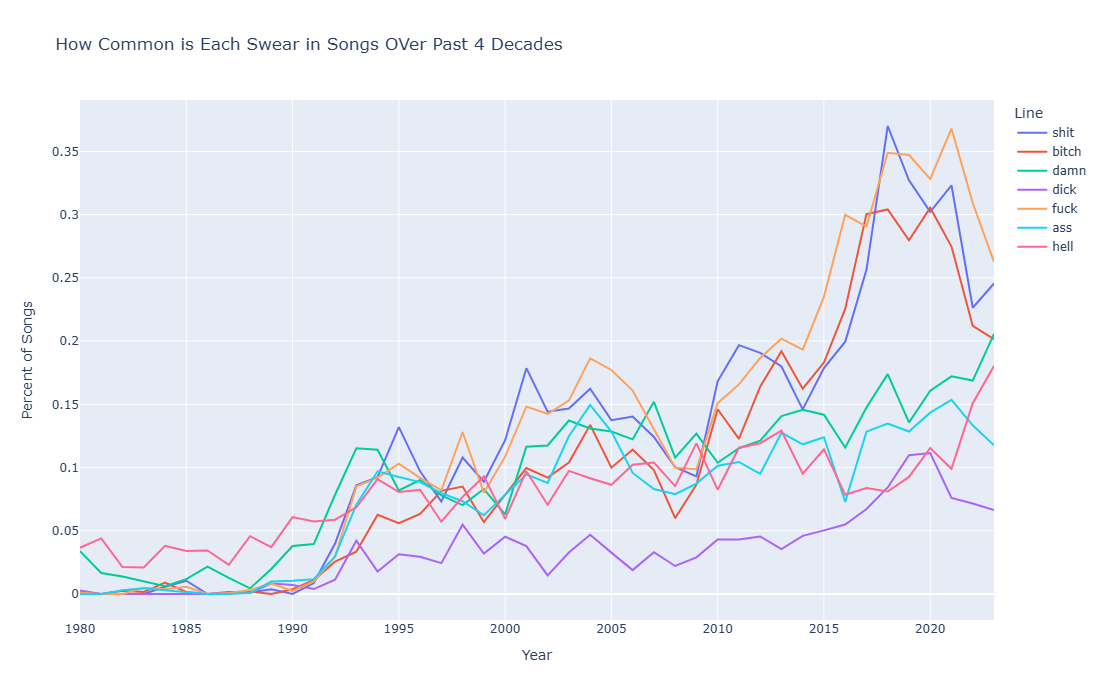

In [734]:
# Melt DataFrame to long format for Plotly
df_melted = which_swear.reset_index().melt(id_vars="index", var_name="Line", value_name="Value")

# Line plot
fig = px.line(
    df_melted,
    x="index",
    y="Value",
    color="Line",
    title="How Common is Each Swear in Songs OVer Past 4 Decades",
    labels={"index": "X-axis", "Value": "Y-axis"}
)

fig.update_layout(
	xaxis_title="Year",
	yaxis_title="Percent of Songs",
    height = 700,
    width = 900
)

AttributeError: '_io.TextIOWrapper' object has no attribute 'columns'

In [768]:
pd.read_csv('most_byyear.csv', index_col = 0)

,title,artist,rank,tot_words,shit,bitch,damn,dick,fuck,ass,hell,total_swear,percent_swear
1980,Damned If I Do,The Alan Parsons Project,47,83,0,0,10,0,0,0,0,10,0.120482
1981,Hello Again,Neil Diamond,25,58,0,0,0,0,0,0,12,12,0.206897
1982,Valley Girl,Frank Zappa,62,471,0,4,0,0,0,0,0,4,0.008493
1983,Memphis,Joe Jackson,94,150,0,0,0,0,0,0,10,10,0.066667
1984,Hello Again,The Cars,60,108,0,0,0,0,0,0,31,31,0.287037
1985,Hello Again,The Cars,28,108,0,0,0,0,0,0,31,31,0.287037
1986,Vienna Calling,Falco,70,418,0,0,0,0,0,0,19,19,0.045455
1987,Niagara Falls,Chicago,91,94,0,0,0,0,0,0,6,6,0.063830
1988,Girls Ain't Nothing But Trouble,D.J. Jazzy Jeff & The Fresh Prince,79,468,0,0,0,0,0,0,10,10,0.021368
1989,Girls Ain't Nothing But Trouble,D.J. Jazzy Jeff & The Fresh Prince,92,468,0,0,0,0,0,0,10,10,0.021368
